    Simple implementation, considering a deck of n size of sequential numbers

    Only consdering P1 and P2, each player starts with 1 card

    If cards are adjacent then its considered a straight
    i.e P1 := 1, Community Board (CB) := 2, P2 := 4
    P1 hand = 12 straight
    P2 hand = 41 high card

    P1 wins

        P1 := 1, CB := 2, P2 := 3

    P1 hand = 12 straight
    P2 hand = 23 straight

    P2 wins

    If not take highest card then kicker

        i.e P1 := 1, Community Board (CB) := 4, P2 := 2
    P1 hand = 41 High Card
    P2 hand = 42 High Card

    2 Kicks, P2 Wins.

    Tree of game
        if p1 bets, then p2 can bet or fold
        if p1 checks, then p2 can bet or check
        if p1 checks, then p2 bets, p1 can bet or fold

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

# Size of deck, adjust for bigger or smaller decks
decksize = 6

# generates deck
deck = list(range(1, decksize + 1))

# total runs for experimental data on the results of p1 vs p2
total_runs = 1000

# total number of iterations for training and playing
total_iter = 100000

step = 0.005

# scores from each experimental run
p1_scores = []
p2_scores = []

# adjusting weights of p1/p2 after p1 and p2 both bet
def bb(result):
    idx1 = (p1 - 1, board - 1)
    idx2 = (p2 - 1, board - 1)
    delta = step * (1 if result else -1)

    p1_b[idx1] = np.clip(p1_b[idx1] + delta, 0, 1)
    p2_b[idx2] = np.clip(p2_b[idx2] - delta, 0, 1)

# adjusting weights of p1/p2 after p1 bet then p2 fold
def bf(result):
    idx2 = (p2 - 1, board - 1)
    delta = step * (1 if result else -1)

    p2_b[idx2] = np.clip(p2_b[idx2] - delta, 0, 1)

# adjusting weights of p1/p2 after p1 check, p2 bet and p1 bet
def cbb(result):
    idx2 = (p2 - 1, board - 1)
    idx1 = (p1 - 1, board - 1)
    delta = step * (1 if result else -1)

    p1_cb[idx1] = np.clip(p1_cb[idx1] + delta, 0, 1)
    p2_cb[idx2] = np.clip(p2_cb[idx2] - delta, 0, 1)

# adjusting weights of p1/p2 after p1 check, p2 bet and p1 fold
def cbf(result):
    idx1 = (p1 - 1, board - 1)
    delta = step * (1 if result else -1)

    p1_cb[idx1] = np.clip(p1_cb[idx1] + delta, 0, 1)

# function to resolve current hand and determine winner/loser
def resolve_hand(p1, p2, board):
    # if p1 has straight
    if abs(p1 - board) == 1:
        if abs(p2 - board) == 1:
            return max(p1, board) > max(p2, board)
        else:
            return True
    # if p2 has straight
    elif abs(p2 - board) == 1:
        return False
    else:
        return p1 > p2

In [38]:
for run in range(total_runs):
    # for each run generate a new matrix for each possible action
    # p1_b[x, y] determines some weight for what the model should do. x 
    # corresponds with p1's hand, y corresponds to the cards on the board
    
    # weights for p1 first turn betting
    p1_b = np.round(np.random.rand(decksize, decksize), 3)
    # weights for p1 calling bet after checking
    p1_cb = np.round(np.random.rand(decksize, decksize), 3)
    # weights for p2 betting if p1 bet
    p2_b = np.round(np.random.rand(decksize, decksize), 3)
    # weights for p2 betting if p1 checked
    p2_cb = np.round(np.random.rand(decksize, decksize), 3)

    # filling diagonals as 0 for clarity, since x/y corresponds to hand and 
    # board it cannot overlap
    np.fill_diagonal(p1_b, 0)
    np.fill_diagonal(p1_cb, 0)
    np.fill_diagonal(p2_b, 0)
    np.fill_diagonal(p2_cb, 0)

    # Training values
    for i in range(total_iter):
        # drawing cards for p1, p2 and board
        p1, p2, board = np.random.choice(deck, size=3, replace=False)

        # probability of taking action
        # real a random variable U ~ [0, 1], if the realisation of U is less 
        # then the corresponding weight in p1_b, then an action is taken.
        # Same logic is applied to the other weights
        p1_bet = np.random.rand() < p1_b[p1 - 1, board - 1]
        
        if p1_bet:
            p2_bet = np.random.rand() < p2_b[p2 - 1, board - 1]
            if p2_bet:
                # Both bet: resolve hand
                result = resolve_hand(p1, p2, board)
            else:
                # P2 folded: P1 wins
                result = True
        else:
            p2_bet = np.random.rand() < p2_cb[p2 - 1, board - 1]
            if p2_bet:
                p1_checkbet = np.random.rand() < p1_cb[p1 - 1, board - 1]
                if p1_checkbet:
                    # Both bet after check: resolve hand
                    result = resolve_hand(p1, p2, board)
                else:
                    # P1 folded: P2 wins
                    result = False
            else:
                # Both checked: resolve hand
                result = resolve_hand(p1, p2, board)
        
        # After outcome of the hand, adjust the models current weights for each
        # action, basically just training a perceptron by hand with extra steps
        # adjusting odds for every step
        if p1_bet:
            if p2_bet:
                bb(result)
            else:
                bf(result)
        else:
            if p2_bet and p1_checkbet:
                cbb(result)
            elif p2_bet and not p1_checkbet:
                cbf(result)

    # Testing values
    p1_score = 0

    # after models have been trained, test it over some iterations.
    for i in range(total_iter):
        p1, p2, board = np.random.choice(deck, size=3, replace=False)
        
        # overall logic is functionally identical to training logic, just 
        # keeping track of scores, since its a 2 player zero sum game no need to
        # track the score of p2, just multiply p1 score by -1 to get p2.
        p1_bet = np.random.rand() < p1_b[p1 - 1, board - 1]
        if p1_bet:
            p2_bet = np.random.rand() < p2_b[p2 - 1, board - 1]
            if p2_bet:
                p1_score += 2 if resolve_hand(p1, p2, board) else -2
            else:
                p1_score += 1
                
        else:
            p2_bet = np.random.rand() < p2_cb[p2 - 1, board - 1]
            if p2_bet:
                p1_checkbet = np.random.rand() < p1_cb[p1 - 1, board - 1]
                if p1_checkbet:
                    p1_score += 2 if resolve_hand(p1, p2, board) else -2
                else:
                    p1_score -= 1
            else:
                # Both checked: resolve hand
                p1_score += 1 if resolve_hand(p1, p2, board) else -1
    
    p1_scores.append(p1_score)

[-3872, -33142, 38704, 35434, 3691, -30056, -15334, -38449, -25342, 15672, 15273, 678, 15672, 13240, -5326, -27149, 56172, 14882, 35017, 14040, 37576, 115248, 19327, 8334, 13589, 79090, 54610, -27508, 18460, -15116, 6415, 34227, -46024, -12726, 11950, -62515, 40730, -15054, -7561, 926, 8348, 8545, -68952, 9992, -10615, 29528, -5023, -27822, -12392, -25996, 86336, 44046, -43794, 21648, 9506, 39506, 54970, 55081, -4984, 23248, -7662, -7593, 3976, -11014, -3273, -1914, 5167, 489, 18215, -16440, -50166, -10110, 34348, -31823, -43349, -28203, -50907, 10103, 31101, 25519, -10808, 6891, 33025, 54830, 33805, -25818, -16165, 70113, 21918, 9013, -2494, -53753, 41001, 54456, 15149, 44202, 51520, -14334, 32831, -15491, 21225, -8306, 22627, 5981, -6044, 15457, 42946, 38185, -15388, -31116, -11171, -48777, -2207, 1580, 4760, -15237, -18445, -28669, 18576, -19567, -4975, -21129, 921, 10840, -8561, -43140, 8630, -8162, 21481, -5571, -4365, 44113, 19680, 49098, 64361, 57187, -12618, 41123, 40458, -9010

mean of p1 scores per hand 0.09166645
standrad deviation 0.3215481514111028
T-test p-value: 1.0204993295307248e-18


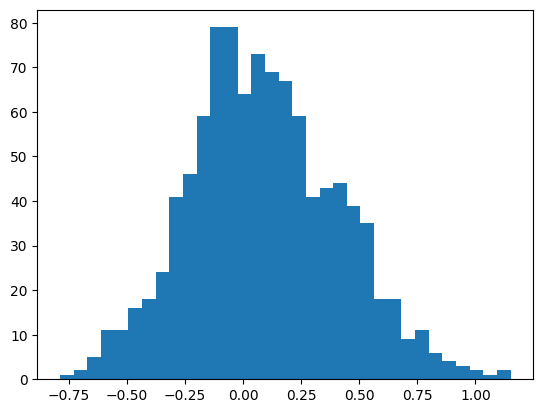

In [42]:
# shrink p1_scores by total iter to get the expectation per hand
p1_expectation = np.array(p1_scores) / total_iter

# the assumption is made that multiple local maximums exist, that or values do 
# not converge exactly on the optimal solution, so instead a statistical result
# is taken.

# mean of expectation per hand
print(f"mean of p1 scores per hand {np.mean(p1_expectation)}")
# standard deviation
print(f"standrad deviation {np.std(p1_expectation)}")

# applying a t-test to determine how signifcant the results are, whether p1
# found an advantage compared to p2. 
t_stat, p_val = ttest_1samp(p1_expectation, 0)

print(f"T-test p-value: {p_val}")

# Discussion
# Why does p1 have an advantage compared to p2? p2 has the information and 
# positional advantage since p1 acts first, why is p2 in such a bad position?
#
# Are the values converging to local maximums, or are the values consistently 
# converging to a global maximum? Does this hold true for the weight matrix
# for all the actions?
#
# Adding additional actions/features to the game? Is this the most efficient 
# route progresssing (creating an independent matrix entry for every possible 
# action) or is there a computational method that may have decreased accuracy 
# but much better run times?
# 
# For the game currently there are 2 players, 2 possible hand types (high card
# and straight) and 3 actions (check, bet fold), cards only have number and no
# suite. By adding additional players, additional hand combos, and additional 
# types of cards, how would the time complexity of this algorithm grow with
# additional characteristics?

plt.hist(p1_expectation, bins = 33)
plt.show()